# Lineání regrese pro policii

Budeme zkoumat závislost váhy na výšce.
Naším úkolem bude zjistit, zda je vhodným modelem spíše parabola nebo přímka.

## Příprava dat a prozkoumání dat

Nejprve importujeme řadu nástrojů, které se budou hodit.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import patsy as pa

import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

Načteme data o policii, ze kterých vybereme sloupce `weight` a `height`.
Data následně setřídíme podle výšky, což se bude hodit později při plotování.
Nakonec vytvoříme nový sloupec `sq_height` se druhými mocninami výšek.

In [2]:
df = pd.read_csv('police.txt', delimiter='[ \t]+', usecols=['height', 'weight'], engine='python')
df.sort_values(by='height', inplace=True)
df['sq_height'] = df['height'] * df['height']

y = df['weight']
x = df['height']
sx = df['sq_height']

Zobrazíme scatter ploty výšky s vahou a druhé mocniny výšky s vahou.

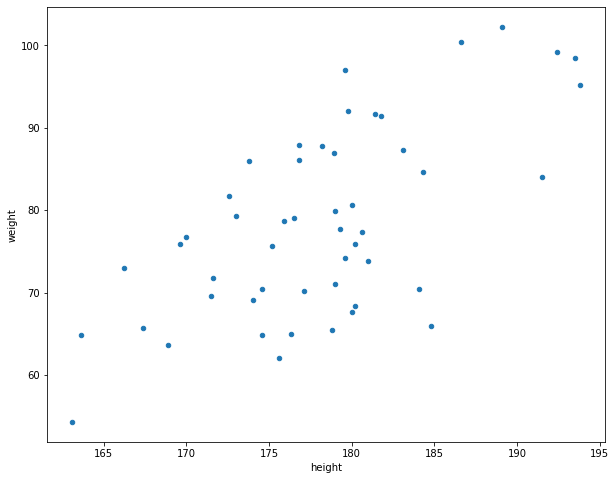

In [3]:
df.plot.scatter('height', 'weight');

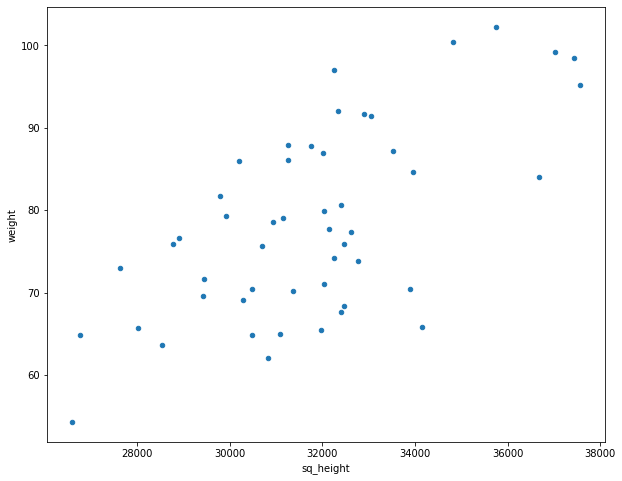

In [4]:
df.plot.scatter('sq_height', 'weight');

Vidíme, že grafy se prakticky nemění.
Tím je už naznačeno, který z modelů později vyhodnotíme jako lepší.

Pro lepší představu o míře lineární závislosti mezi veličinami se můžeme
podívat na korelační matici.

In [5]:
df.corr()

,height,weight,sq_height
height,1.000000,0.648838,0.999602
weight,0.648838,1.000000,0.649975
sq_height,0.999602,0.649975,1.000000


Nakonec ještě přidáme LOWESS křívku pro lepší znázornění závislosti mezi
veličinami před transformací.

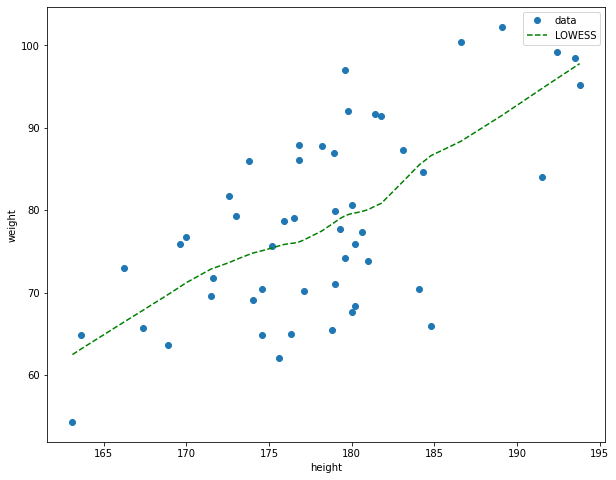

In [6]:
lowess = sm.nonparametric.lowess(y, x, return_sorted=False)

_, ax = plt.subplots()

ax.plot(x, y, 'o', label='data')
ax.plot(x, lowess, 'g--', label='LOWESS')
ax.set_xlabel('height')
ax.set_ylabel('weight')
ax.legend(loc="best");

## Vytvoření modelů

Vytvoříme tedy dva modely.
V prvním budeme vysvětlovat váhu pouze pomocí výšky, v druhém pomocí výšky a
její druhé mocniny.

In [7]:
y, X = pa.dmatrices("weight ~ height", data=df, return_type='dataframe')

lin_model = sm.OLS(y, X)
lin_res = lin_model.fit()

lin_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 weight   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     34.90
Date:                Wed, 19 May 2021   Prob (F-statistic):           3.47e-07
Time:                        21:22:15   Log-Likelihood:                -178.76
No. Observations:                  50   AIC:                             361.5
Df Residuals:                      48   BIC:                             365.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -110.3282     31.963     -3.452      0.001    -174.594     -46.063
height         1.0594      0.179      5.908      0.000       0.699       1.420
==============================================================================
Omnibus:                        2.984   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.225   Jarque-Bera (JB):                1.692
Skew:                          -0.156   Prob(JB):                        0.429
Kurtosis:                       2.155   Cond. No.                     4.57e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.57e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [8]:
y, X = pa.dmatrices("weight ~ height + sq_height", data=df, return_type='dataframe')

par_model = sm.OLS(y, X)
par_res = par_model.fit()

par_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 weight   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     17.26
Date:                Wed, 19 May 2021   Prob (F-statistic):           2.40e-06
Time:                        21:22:16   Log-Likelihood:                -178.65
No. Observations:                  50   AIC:                             363.3
Df Residuals:                      47   BIC:                             369.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    145.0778    573.018      0.253      0.801   -1007.685    1297.841
height        -1.8018      6.412     -0.281      0.780     -14.700      11.097
sq_height      0.0080      0.018      0.446      0.657      -0.028       0.044
==============================================================================
Omnibus:                        2.710   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.258   Jarque-Bera (JB):                1.548
Skew:                          -0.111   Prob(JB):                        0.461
Kurtosis:                       2.167   Cond. No.                     1.45e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Srovnání modelů

Už na první pohled je vidět, že parabolický model je docela problematický.
Závislost váhy na výšce je dokonce záporná a konfidenční intervaly jsou
obrovské.

To je nejspíše zapříčiněno právě velkou podobností mezi výškami a jejich
druhými mocninami (po přeškálování).
To naznačuje i jejich korelace, která má hodnotu více než 0,999.
Veličiny se pak mezi sebou příliš "perou", místo aby každá vysvětlovala
trochu něco jiného.

Prakticky už nyní bych od tohoto modelu upustil.
Zvlášť když přihlédneme k dalšímu objektivnímu indentifikátoru, to jest ke
koeficientu determinace, který je u obou modelu velmi podobný (a zdá se mi
poměrně nízký).

Než ovšem dojde k definitivnímu rozhodnutí, je dobré alespoň zobrazit oba
modely pro vizuální ověření.

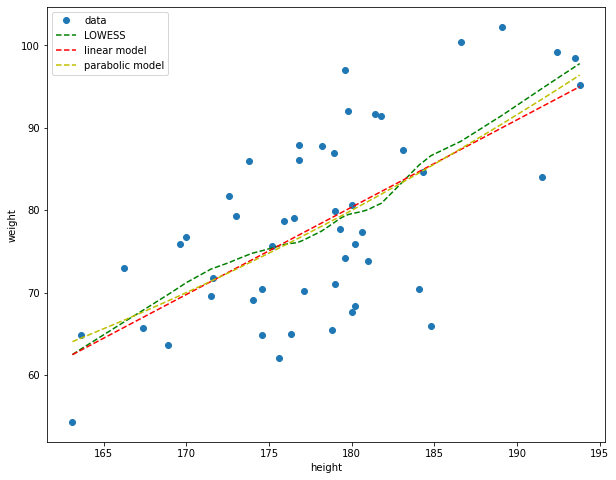

In [9]:
_, ax = plt.subplots()

ax.plot(x, y, 'o', label="data")
ax.plot(x, lowess, 'g--', label='LOWESS')
ax.plot(x, lin_res.fittedvalues, 'r--', label='linear model')
ax.plot(x, par_res.fittedvalues, 'y--', label='parabolic model')
ax.set_xlabel('height')
ax.set_ylabel('weight')
ax.legend(loc="best");

Vidíme, že shoda s LOWESS je poměrně podobná pro oba modely.
Lineární si vede trochu lépe u menších hodnot výšek, oproti tomu parabolický
model má snahu zachytit prohnutí LOWESS křívky uprostřed grafu a trochu lépe
popisuje vyšší hodnoty výšek.

Abychom zachytili toto měnící se zakřivení (jednou je LOWESS křívka nad
našimi modely, jednou pod), potřebovali bychom polynom vyššího stupně.
Je ale dost na pováženou, zda bychom si tím doopravdy pomohli.
Tedy zda by výsledný model byl objektivně lepší.

Myslím tedy, že parabolický model je možné vyřadit právě z toho důvodu, že
oproti lineárnímu nic nového nenabízí a naopak zásadním způsobem podrývá
možnost interpretace.

## Další prozkoumání lineárního modelu

Nyní jsme v situaci, kdy uvažujeme už jen jeden model.
To ovšem neznamená, že jde o vhodný model a je potřeba dále prozkoumat jeho
vlastnosti.
Zejména nás zajímá splnění předpokladů modelu.

Začneme tedy zkoumáním grafu standardizovaných residuí.

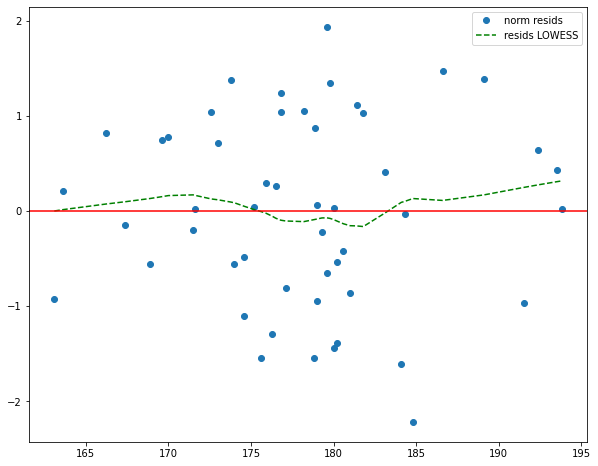

In [10]:
_, ax = plt.subplots()

resids_lowess = sm.nonparametric.lowess(lin_res.resid_pearson, x, return_sorted=False)

ax.plot(x, lin_res.resid_pearson, 'o', label='norm resids')
ax.plot(x, resids_lowess, 'g--', label='resids LOWESS')
ax.axhline(0, c='r')
ax.legend(loc='best');

Z grafu není vidět žádný výrazný systematický prohřešek proti normalitě.
Jak jsme mohli čekat, LOWESS křívka je u krajů o něco výše oproti 0, naopak
je tomu ve středu grafu.
Vidíme také, že nemáme žádná odlehlá pozorování, tj. pozorování u kterého by
standardizované reziduum bylo a absolutní hodnotě větší než 3.

Můžeme tedy ještě pokračovat Q-Q plotem reziduí, abychom dále ověřili jejich
normalitu.

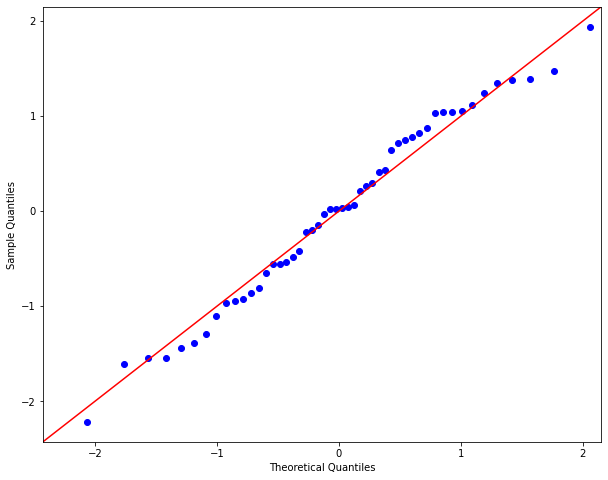

In [11]:
sm.graphics.qqplot(lin_res.resid_pearson, line='45');

Ještě nemám oko vytrénované natolik, abych poznal jaká odchylka od ideálního
chování je v pořádku a jaká už ne.
Tato mi ovšem přijde vcelku v pořádku.

## Závěr

Lineární model se zdá být výrazně lepší volbou než parabolický model z důvodů
popsaných v textu.
Závislost váhy na výšce je statisticky významná, jelikož konfidenční interval
(se spolehlivostí 95 %) koeficientu lineárního členu v lineárního modelu
nepokrývá 0.

Řekl bych, že předpoklady modelu jsou splněny protože rozdělení chyb vcelku
dobře odpovídá teoretickému chování.
